

# NEWS RECOMMENDER SYSTEM


## Project Outline


---





*   Cleaning of the news articles
*   Tackling cold-start problem for new users
*   Generation of clickstream data
*   Content based recommendation system
*   Collaborative filtering based recommender system

Importing all the necessary libraries which will be needed in future.


In [7]:
try:
    import numpy as np
    import pandas as pd
    import csv
    import random
    import matplotlib.pyplot as plt
    import pickle as pk
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.decomposition import TruncatedSVD
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans
    import re
    from sklearn.metrics.pairwise import linear_kernel 
    import string
    from nltk.stem.snowball import SnowballStemmer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk.stem.snowball import SnowballStemmer
    from nltk.stem.wordnet import WordNetLemmatizer
    import nltk
    nltk.download('punkt')
    nltk.download('wordnet')
    stemmer = SnowballStemmer("english")
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy" "pandas" "sklearn" "nltk"
    import numpy
    import pandas as pd
    import pickle as pk
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    import re
    from nltk.stem.snowball import SnowballStemmer
    import nltk
    stemmer = SnowballStemmer("english")
    print('Done!')

[nltk_data] Downloading package punkt to /home/vishal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vishal/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# This part is done to prevent appearance of any future warnings 
# Import warnings filter
from warnings import simplefilter
# Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# News Corpus Data Cleaning

In this section we will clean all the documents. We will do the following cleaning processes:
* remove punctuations
* remove numbers 
* remove stopwords
* remove single characters
* lemmatization


In [3]:
news_articles = pd.read_csv('news_articles.csv')
article_ids = list(news_articles['Article_id'])
Articles = news_articles['Headline'].values

In [4]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

In [5]:
def clean_tokenize(document):
    docs = re.sub('[^\w_\s-]', ' ',document)#removes strigs, full stop
    doc = re.sub('\d|\d+', ' ',docs)#remove math digits
    stop_free = " ".join([stop_word for stop_word in doc.lower().split() if stop_word not in stop])#remove stop words and make lower case
    punc_free = ''.join(punc for punc in stop_free if punc not in exclude)#remove punctuations
    tokens = nltk.word_tokenize(punc_free)#make tokens
    cleaned_article = ' '.join([lemmatizer.lemmatize(item) for item in tokens])
    #cleaned_article = ' '.join([stemmer.stem(item) for item in tokens])#stemming of tokens
    return(cleaned_article)

# The Cold Start Problem


*  We plan to solve it by giving diverse set of articles to users.
*  we will first generate TF-IDF matrix of entire corpus
*  Then, used SVD to reduce dimentionality of the tfidf matrix
*  Silhouette score is calculated to find the optimal number of clusters in k means clustering
*  Then we will recommend articles from these clusters

**1. Generate tfidf matrix model for entire corpus**

In [8]:
cleaned_articles = list(map(clean_tokenize, Articles))
tfidf_matrix = TfidfVectorizer(stop_words='english', min_df=2)
article_tfidf_matrix = tfidf_matrix.fit_transform(cleaned_articles)
terms = tfidf_matrix.get_feature_names()
article_tfidf_matrix #tfidf vector of an article

<10058x13989 sparse matrix of type '<class 'numpy.float64'>'
	with 260621 stored elements in Compressed Sparse Row format>

**2. Using SVD to reduce dimentionality of the tfidf matrix**

In [9]:
svd = TruncatedSVD(n_components=100,random_state=9)
vector_matrix = svd.fit_transform(article_tfidf_matrix)

**3. Evaluation method - Silhouette score to find the optimal number of clusters in k means clustering**

16


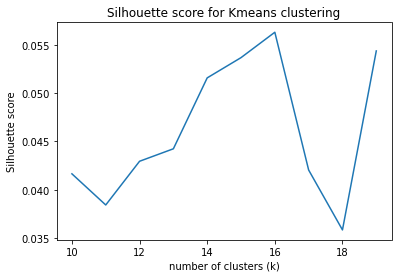

In [11]:
range_n_clusters = list (range(10,20))
x=[]
y=[]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',max_iter=300,n_init=10,random_state=9)
    preds = clusterer.fit_predict(vector_matrix)
    centers = clusterer.cluster_centers_

    score = silhouette_score(vector_matrix, preds)
    #print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    x.append(n_clusters)
    y.append(score)
n_clusters=x[y.index(max(y))]
print(n_clusters) #to print cluster number with max silhouette score

plt.plot(x, y) 
plt.xlabel('number of clusters (k)')  
plt.ylabel('Silhouette score') 
plt.title('Silhouette score for Kmeans clustering')
plt.savefig('k-means_silhouetter_score.png',facecolor='w',edgecolor='w', transparent=False)
plt.show() 

**4. Fitting K-Means to the dataset**

In [12]:
n_clusters=16
kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(vector_matrix)
kmeans_fit=kmeans.fit(vector_matrix)

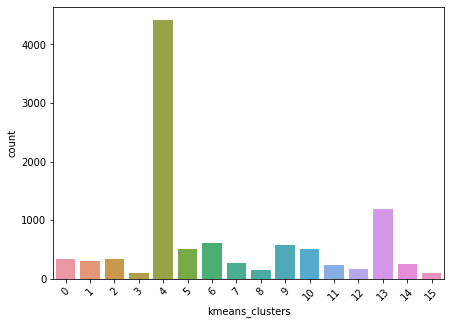

In [13]:
kmeans_df = pd.DataFrame()
kmeans_df['kmeans_clusters'] = kmeans.fit(vector_matrix).labels_
#label=kmeans.fit(vec_matrix_pca).labels_
fig, ax = plt.subplots(figsize=(7,5))
sns.countplot(x= 'kmeans_clusters', data=kmeans_df,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.savefig('cluster.png',facecolor='w',edgecolor='w', transparent=False)

**5. Recommend diverse articles from the clusters**

In [14]:
def recommend_diverse_articles():
  l=[]
  recommend=[]
  cluster_label=np.array(kmeans_fit.labels_)
  for i in range(n_clusters):
    b=np.where(cluster_label==i)
    c=random.choice(b[0])
    recommend.append(c)
  for i in range(10-n_clusters):
    f=random.choice(range(1,len(cleaned_articles)))
    if f not in recommend:
      recommend.append(f)
  #print(recommend)
  #for i in range(len(recommend)):
    #print('Article %d : ' % (i+1) , news_articles['Headline'][recommend[i]])
  return recommend

# Clickstream data

* We generate three types of users as per our assumptions.
* We serve diverse articles to all users in session #1
* from next sessions it serves random articles to new users and personalized articles to repeat users.
* Clickstream data is stored in a csv file for further use.



In [15]:
class Click_data:
    
    def __init__(self,article_ids,num_of_users):
        self.bounce_users_ids=[]
        self.one_time_users_ids=[]
        self.regular_users_ids=[]
        self.user_ids = []
        self.user_articles = {}
        self.clickstream = {}
        self.article_ids = article_ids
        self.num_of_users = num_of_users
        self.fields = ['user id','session id','article id' ,'click','ratings','time spent', 'user type']
        csvfile = open('clickstream.csv', 'w')
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(self.fields)
        csvfile.close()

    def gen_new_users(self):
        self.bounce_users_ids=[]
        self.one_time_users_ids=[]
        #self.user_articles = {}
        #assign randomly ids to various users types
        for i in range(int(self.num_of_users*0.25)):
            r = random.randint(1000000,9999999)

            while r in self.user_ids:                               
                r = random.randint(1000000,9999999) 
                
            self.user_ids.append(r)          #to keep track of all the users
            self.bounce_users_ids.append(r)   #to keep track of bounce users
            #self.user_articles[r] = random.choices(self.article_ids,k=10) #random 10 articles assigned for now
            self.user_articles[r] = recommend_diverse_articles()
            
        for i in range(int(self.num_of_users*0.50)):
            r = random.randint(1000000,9999999)
            while r in self.user_ids:
                r = random.randint(1000000,9999999)
            self.user_ids.append(r)          #to keep track of all the users
            self.one_time_users_ids.append(r) #one time users
            
            # diverse articles recommender - kmeans : add over here
            #self.user_articles[r] = random.choices(self.article_ids,k=10)
            self.user_articles[r] = recommend_diverse_articles()
    
    def gen_regular_users(self):
        #These are regular users we dont have to generate them in every iteration of new session
        for i in range(int(self.num_of_users*0.25)):
            r = random.randint(1000000,9999999)
            while r in self.user_ids:
                r = random.randint(1000000,9999999)
            self.user_ids.append(r)          #to keep track of all the users
            self.regular_users_ids.append(r) #repeat users
            #self.user_articles[r] = random.choices(self.article_ids,k=10)
            self.user_articles[r] = recommend_diverse_articles()

    def regular_users(self):
      # add recommender system in this code.... 
      for r in self.regular_users_ids:
        #self.user_articles[r] = random.choices(self.article_ids,k=10)
        self.user_articles[r] = recommend(r,10)


    # a function to generate clickstream 
    def gen_clickstream(self,session_id):
      
      if(session_id == 1):
        self.gen_new_users()
        self.gen_regular_users()  #need to generate only once

      else:
        self.gen_new_users()
        self.regular_users()

      self.clickstream = {}
      timespend_type1 = np.random.normal(0,0,int(self.num_of_users*0.25))               # no clicks or reads

      mean2 = [100,3]
      cov2 = [[600.  ,21.35714286],
        [ 21.35714286 ,0.77267857]]

      timespend_type2 = [np.random.multivariate_normal(mean2, cov2,random.choices([1,2,3],[0.7,0.2,0.1])) for i in range(int(self.num_of_users*0.50))]

      mean3 = [180,3]
      cov3 =  [[1.22142857e+03, 2.28928571e+01],
              [2.28928571e+01, 4.41250000e-01]]
      timespend_type3 = [np.random.multivariate_normal(mean3, cov3,random.choices([1,2,3,4],[0.4,0.3,0.2,0.1])) for i in range(int(self.num_of_users*0.25))]


      for i in range(len(self.bounce_users_ids)):
          self.clickstream[self.bounce_users_ids[i]] = [[session_id,random.choice(self.user_articles[self.bounce_users_ids[i]]),'no','0',timespend_type1[i],'bounce']] 

      for i in range(len(self.one_time_users_ids)):
          temp = []
          for j in timespend_type2[i]:
              temp.append([session_id,random.choice(self.user_articles[self.one_time_users_ids[i]]),'yes',round(j[1]),round(j[0]),'one time'])
          self.clickstream[self.one_time_users_ids[i]] = temp

      for i in range(len(self.regular_users_ids)):
          temp = []
          for j in timespend_type3[i]:
              temp.append([session_id,random.choice(self.user_articles[self.regular_users_ids[i]]),'yes',round(j[1]),round(j[0]),'regular'])
          self.clickstream[self.regular_users_ids[i]] = temp

      with open('clickstream.csv', 'a') as csvfile: 
        csvwriter = csv.writer(csvfile)
        for i in list(self.clickstream.keys()):
            for j in self.clickstream[i]:
                # writing the data rows 
                j.insert(0,i)
                csvwriter.writerow(j)
        clickstream_data = pd.read_csv('clickstream.csv')
      return clickstream_data


In [16]:
f=Click_data(article_ids,1000) #give article ids and number of users
clickstream_data=f.gen_clickstream(1) #1 represent session id

## Visualization of user clickstream after session 1

No handles with labels found to put in legend.


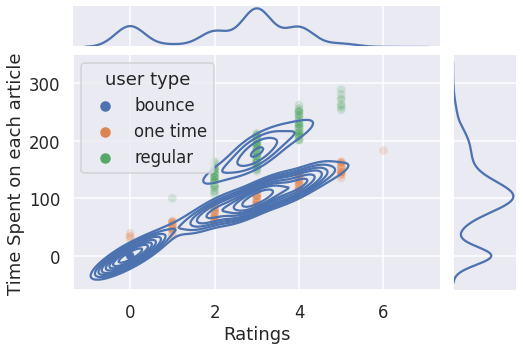

In [17]:
sns.set(context='talk')

#add a column for the type of user
ids = list(clickstream_data['user id'])

#plot and save the multi-variate distribution
g = sns.jointplot(x="ratings", y="time spent", data=clickstream_data, kind="kde")
g.plot_joint(sns.scatterplot, data=clickstream_data, hue = 'user type',alpha=0.2)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Ratings", "Time Spent on each article")
g.fig.set_figwidth(8)
g.fig.set_figheight(5)
plt.legend(loc='lower right',framealpha=0)
plt.savefig('clickstream.png',facecolor='w',edgecolor='w', transparent=False)
plt.show()

# Content based recommender

In [18]:
user_data = pd.read_csv('clickstream.csv')
cosine_similarities = linear_kernel(article_tfidf_matrix, article_tfidf_matrix) 
results = {}
for idx, row in news_articles.iterrows():
   similar_indices = cosine_similarities[idx].argsort()[:-100:-1] 
   similar_items = [(cosine_similarities[idx][i], news_articles['Article_id'][i]) for i in similar_indices] 
   results[row['Article_id']] = similar_items[1:]

news_articles = pd.read_csv('news_articles.csv')
article_ids = list(news_articles['Article_id'])
Articles = news_articles['Headline'].values

In [19]:
def item(id):  
  return news_articles.loc[news_articles['Article_id'] == id]['Headline'].tolist()[0].split(' - ')[0] 
# Just reads the results out of the dictionary.def 
def recommend(user_id, num):
    ids = user_data['user id'].values
    i = np.where(ids == user_id)[0][0]
    item_id = user_data['article id'].values[i,]
    L = []
    for rec in results[item_id][:num]:
        L.append(rec[1])
    return L

In [20]:
#generating clickstream data for next session using tfidf recommender
for i in range(2,9):
  f.gen_clickstream(i) #sessions 2 to 8

# Collaborative filtering based recommender system

**Collaborative filtering based on user similarity score**

 *  created a users vs document rating matrix
 *  use it to find the cosine similarity between different users
 *  We estimate the unknown rating by taking weighted average and then recommend 10 articles based on the estimated ratings.


In [33]:
user_data = pd.read_csv('clickstream.csv')
class Collaborative_Cosine_Similarity_Recommender():
    MODEL_NAME = 'CCSR'
    def __init__(self,article_tfidf_matrix,user_data,news_articles,cleaned_articles):
        self.article_tfidf_matrix = article_tfidf_matrix
        self.user_id = list(set(user_data['user id']))
        self.user_data = user_data.set_index('user id')
        self.news_articles = news_articles
        self.cleaned_articles = np.array(cleaned_articles)
        self.number_of_recommendations = 10
        self.article_ids = list(set(self.news_articles['Article_id']))
        self.rat_matrix = np.zeros((len(self.user_id),len(article_ids)))      
        self.k_nearest_users = 10
        
    def interacted_ids(self,userid):      
      article_ids = self.user_data.loc[userid]['article id']
      ratings_given = self.user_data.loc[userid]['ratings']
      if isinstance(article_ids, (np.int64)):
        article_ids = [article_ids]
        ratings_given = [ratings_given]
      else:
        article_ids = list(article_ids)
        ratings_given = list(ratings_given)
      return article_ids, ratings_given
    
    def news_articles_id(self,articles_read_ids):
      article_read_ind = []
      for id in articles_read_ids:
        article_read_ind.append(np.where(self.news_articles['Article_id'] == id)[0][0])
      return article_read_ind

    def rating_mat_update(self):
      for ind in range(len(self.user_id)):
        articles_read_ids, ratings = self.interacted_ids(user_id[ind])
        articles_read_ind = self.news_articles_id(articles_read_ids)
        self.rat_matrix[ind][articles_read_ind] = ratings

    def recommend_articles(self,userid):
      uid = np.where(userid == np.array(self.user_id))[0][0]
      self.rating_mat_update()
      user_similarity_score = cosine_similarity(self.rat_matrix, self.rat_matrix[uid].reshape(1,self.rat_matrix.shape[-1])).flatten()
      similar_user_ind = np.argsort(user_similarity_score)[::-1][1:self.number_of_recommendations+1]

      for ir in range(self.rat_matrix.shape[-1]):
        tot = 0
        num = 0
        for ik in range(self.k_nearest_users):
          num+=user_similarity_score[similar_user_ind[ik]]*self.rat_matrix[similar_user_ind[ik]][ir]
          tot+=user_similarity_score[similar_user_ind[ik]]
        if(tot != 0):
          self.rat_matrix[uid][ir] = num/tot
      recommended_articles_ind = np.argsort(self.rat_matrix[uid])[::-1]
      recommended_articles_id = np.array(news_articles['Article_id'])[recommended_articles_ind]
      final_recommended_articles_ind = [np.where(article_id == news_articles['Article_id'])[0][0] for article_id in recommended_articles_id][:self.number_of_recommendations]
      return recommended_articles_id[:self.number_of_recommendations],news_articles['Headline'][recommended_articles_ind][:self.number_of_recommendations]


In [34]:
cssr = Collaborative_Cosine_Similarity_Recommender(article_tfidf_matrix,user_data,news_articles,cleaned_articles)

# Recommending via Collaborative filtering

In [35]:
user_id = list(set(user_data['user id']))
userid = random.choice(user_id)   #choosing a user id
print(userid)

ids = user_data['user id'].values
i = np.where(ids == userid)[0][0]
art = user_data['article id'].values[i,]

print ('As you have liked this article\n', item(art))

print ('\n here are some recommendations')
cssr = Collaborative_Cosine_Similarity_Recommender(article_tfidf_matrix,user_data,news_articles,cleaned_articles)
cssr.recommend_articles(userid)


6101320
As you have liked this article
 Former Union Minister and BJP leader Dilip Gandhi passed away on Wednesday morning. He had tested positive for COVID-19 and was undergoing treatment at a hospital in Delhi. PM Narendra Modi expressed grief and said, "He will be remembered for his rich contributions to community service and helping the poor. He made numerous efforts to strengthen the BJP in Maharashtra."

 here are some recommendations


(array([4223, 5910, 9525, 3350, 3356, 3355, 3354, 3353, 3352, 3351]),
 4223    Former Union Minister and BJP leader Dilip Gan...
 5910    The Lok Sabha on Wednesday passed the National...
 9525    Madhya Pradesh BJP has sacked Vijay Tripathi f...
 3350    As many as 43,846 new coronavirus cases have b...
 3356    Speaking about the limited opportunities that ...
 3355    Speaking about working with her 'Ishaqzaade' c...
 3354    Interior designer Gauri Khan spoke about how s...
 3353    Veteran Bollywood actress Sharmila Tagore rece...
 3352    The Ashoka University board, Pratap Bhanu Meht...
 3351    Ex-England captain Michael Vaughan has mocked ...
 Name: Headline, dtype: object)

# Recommending via Content based filtering

In [36]:
for i in recommend(userid, 10):
    article = item(i)
    print (i)
    print ('Here are some recommendations\n', article)

4085
Here are some recommendations
 President Ram Nath Kovind on Wednesday expressed his grief over the death of former Union Minister Dilip Gandhi, who had tested COVID-19 positive and was undergoing treatment at a Delhi hospital. "He was a popular leader who always strived for the development of Ahmednagar and Maharashtra," the President tweeted. Gandhi was a three-time MP from Ahmednagar South Lok Sabha seat.
7821
Here are some recommendations
 PM Narendra Modi said that he's saddened by the demise of BJP's Lok Sabha MP from Madhya Pradesh's Khandwa Nandkumar Singh Chauhan. "He'll be remembered for his contributions to Parliamentary proceedings, organisational skills and efforts to strengthen BJP across Madhya Pradesh," he tweeted. Chauhan had tested COVID-19 positive and was undergoing treatment in Gurugram's Medanta Hospital.
4898
Here are some recommendations
 Actress Shruti Haasan has expressed grief over the demise of Tamil film director SP Jananathan.  She tweeted, "It is with

In [37]:
userid

6101320